In [1]:
using Pkg
using Distributions
#Pkg.add("Optim")
#Pkg.add("PyPlot")
#Pkg.add("LinearAlgebra")
using Optim
using PyPlot
using LinearAlgebra

In [2]:
function market_shares( p, wtp, alpha)
    return exp.(wtp .- alpha.*p) / (1 + sum( exp.(wtp .- alpha.*p) ) )
end


function mco_profits(p,phi,mu,wtp, alpha)
    return market_shares(p, wtp, alpha) .* ( p - mu .* phi )
end


function price_profits(phi,mu,wtp,alpha)
    diff =  5.
    p = [1.,1.]
    profits = [0.,0.]
    
    maxiter = 100
    
    while (maxiter >=0) & (diff > 10e-7)
        #set up objective
        obj1(p0) = -1*mco_profits( [p0[1], p[2]],phi,mu,wtp,alpha)[1]
        res1 = optimize(obj1, [p[1]] , BFGS())
        obj2(p0) = -1*mco_profits( [p[1], p0[1]] ,phi,mu,wtp,alpha)[2]
        res2 = optimize(obj2,[p[2]], BFGS())
        
        #update loop variables
        diff = max( abs( res1.minimizer[1] - p[1] ), abs( res2.minimizer[1] - p[2] ) )
        maxiter = maxiter-1
        
        #update result
        p = [res1.minimizer[1],res2.minimizer[1]]
        profits =  [-1*res1.minimum, -1*res2.minimum]        
    end
    return p, profits
end


#arbitrary outside option... passive beliefs
function nash_in_nash(phi, mu, beta, wtp, alpha,  mc; pi0=0.)
    p, profits = price_profits(phi,mu,wtp,alpha)
    s = market_shares(p,wtp,alpha)
    return   profits.^beta .* (sum(mu .* s .* (phi .- mc) ) - pi0).^(1 .- beta)
end

print( nash_in_nash( [3,3], [.5,.5] , [.5,.5], 5., .5 , .5) )

[1.47478, 1.47478]

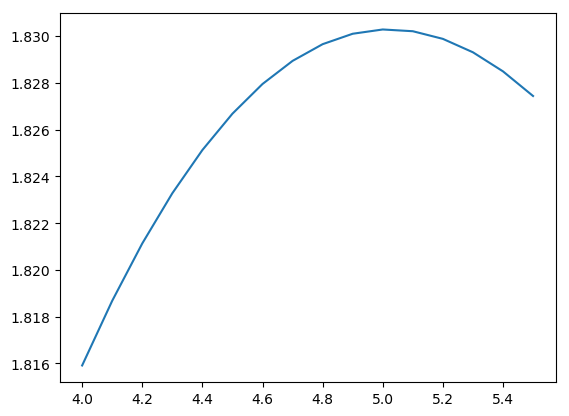

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcb5c201ba8>

In [3]:
obj(x) = nash_in_nash( [x,4.56294],  [.5,.5] , [.5,.5], 5., .5 , .5 )[1]
xs = collect(40:55)/10
objs = []
for x=xs 
    append!(objs,obj(x))
end 

plot(xs,objs)

In [4]:
function bargain_helper(phi, mu, beta, wtp, alpha, mc)
    """solve each firm 1s optimization holding theta 2 fixed"""
    
    obj1(phi0) = -1*nash_in_nash( [phi0[1], phi[2]] , mu,  beta, wtp, alpha, mc)[1]
    res1 =  optimize(obj1, [phi[1]], BFGS())

    obj2(phi0) = -1*nash_in_nash( [phi[1], phi0[1]], mu,  beta, wtp, alpha, mc)[2]
    
    
    res2 =  optimize(obj2, [phi[2]], BFGS())
    
    return [ res1.minimizer[1], res2.minimizer[1] ]
end

println( bargain_helper([3.,3.], [.5,.5] , [.5,.5], 5., .5 , .5) )

[5.31521, 5.31521]


In [9]:
function simult_bargain(mu, beta, wtp, alpha, mc)
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  5.
    phi = [3*alpha, 3*alpha]

    maxiter = 100
    while (maxiter >=0) & (diff > 10e-7)
        #seems as though there is a contraction mapping here, need to think more about why
        phi_new = bargain_helper(phi, mu, beta, wtp, alpha, mc)
        
        #update loop variables
        diff = maximum( abs.(phi - phi_new) )
        maxiter = maxiter-1
        
        #update phi
        phi = phi_new
    end
    return phi
end
    
print(simult_bargain([.2,.2] , [.5,.5], 2., 0.5 , .5) )

[6.77663, 6.77663]

In [14]:
function calc_derivatives(phi,mu,wtp,alpha;h=0.0001)
    gradient_profit = zeros(2,2)
    gradient_s = zeros(2,2)
    for i=1:2
        
        hs = zeros(2)
        hs[i] = h
        p1,profit1 = price_profits(phi+hs,mu,wtp,alpha)
        p2,profit2 = price_profits(phi-hs,mu,wtp,alpha)
        println(p1,p2)
        
        
        s1 = market_shares( p1, wtp, alpha)
        s2 = market_shares( p2, wtp, alpha)
        
        gradient_profit[:,i] =  1/(2*h) .* (profit1 - profit2) 
        gradient_s[:,i] = 1/(2*h) .* (s1 -s2) 
    end
    return gradient_profit, gradient_s
end



calc_derivatives([6.77663, 6.77663],[.2,.2], 2., .5)

[4.28437, 4.28436][4.28434, 4.28435]
[4.28436, 4.28437][4.28435, 4.28434]


([-0.0604058 0.0205671; 0.0205671 -0.0604058], [-0.0140819 0.00479463; 0.00479463 -0.0140819])

In [13]:
function calc_hospital_cost(phi,mu,beta,wtp,alpha)
    gradient_profit, gradient_s = calc_derivatives(phi,mu,wtp,alpha)
    price, profits = price_profits(phi,mu,wtp,alpha)
    shares = market_shares(phi,wtp,alpha)
    mc = zeros(2)
    for i=1:2
        not_i = mod(i,2)+1
        
        A = sum( mu .*shares .* phi) 
        B = sum(mu .* shares)
        
        dA = mu[i]*(gradient_s[i,i]*phi[i] + shares[i]) + mu[not_i]*gradient_s[not_i,i]*phi[not_i]
        dB = mu[i]*(gradient_s[i,i]) + mu[not_i]*gradient_s[not_i,i]
        
        C = -beta[i]/(1-beta[i]) * gradient_profit[i,i]/profits[i]
        
        
        mc[i] = (C*A - dA)/(C*B - dB)
        println(C, " ", B, " ", dB," ",C*B, " ",  C*B - dB)
        
        #mc[i] = mc[i]/(gradient_s[i,i]*phi[i] + shares[i] + gradient_s[not_i,i]*phi[not_i] - sum(shares))
    end
    return mc
end 

print(calc_hospital_cost([6.77663, 6.77663], [.2,.2],[.5,.5], 2., .5))

[4.3537, 4.35369][4.35367, 4.35368]
[4.35369, 4.3537][4.35368, 4.35367]
0.06555132131929456 0.057336846489350037 -0.001875336428980301 0.0037585060476584505 0.005633842476638751
0.06555132131929456 0.057336846489350037 -0.001875336428980301 0.0037585060476584505 0.005633842476638751
[2.12077, 2.12077]